# FICO challenge

Took 20 minutes to write this (with ~6 years relevant experience)

ML code is 2 lines

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk

In [2]:
pd.__version__, np.__version__, sk.__version__

('1.3.5', '1.22.1', '1.0.2')

In [3]:
p = "heloc_dataset_v1.csv"
data = pd.read_csv(p)

data.shape

(10459, 24)

# Data

In [4]:
data.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


In [5]:
y_var = 'RiskPerformance'
data[y_var].value_counts()

Bad     5459
Good    5000
Name: RiskPerformance, dtype: int64

In [6]:
X = data.drop(y_var, axis=1)
y = data[y_var]

X.shape, y.shape

((10459, 23), (10459,))

# Train

In [7]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)

# 1 = "Good", 0 = "Bad"
y.shape, np.mean(y)

((10459,), 0.4780571756382063)

In [9]:
# C.R. likes 10-fold CV
outer_cv = 10
inner_cv = 5

random_state = 99
n_jobs = 8
verbose = 1

scoring = ['accuracy', 'roc_auc']

In [10]:
# saw convergence errors, so increased iters this until they disappeared
max_iter = 2000

# the greatest single line of ML code, ever
lrcv = LogisticRegressionCV(cv=inner_cv, max_iter=max_iter, random_state=random_state)

results = cross_validate(lrcv, X, y, cv=outer_cv, scoring=scoring, n_jobs=n_jobs,
                         return_estimator=True, verbose=verbose)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:   18.3s remaining:   12.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:   24.7s finished


# Evaluate

Get mean, std dev, and # of scores, for each of 2 performance metrics

In [11]:
scores = results['test_accuracy']
np.mean(scores), np.std(scores), len(scores)

(0.6988261502008105, 0.045977352285483775, 10)

In [12]:
scores = results['test_roc_auc']
np.mean(scores), np.std(scores), len(scores)

(0.772223649897503, 0.03907796255018936, 10)

# Explain

Plot average (std) of coefficients

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
%matplotlib inline

In [15]:
# collect coefs from 10 (outer cv) models
dfs = [] 

for est in results['estimator']:
    df = pd.DataFrame({'coef': est.coef_.flatten(), 'column': X.columns})
    dfs.append(df)

In [16]:
coefs_df = pd.concat(dfs)

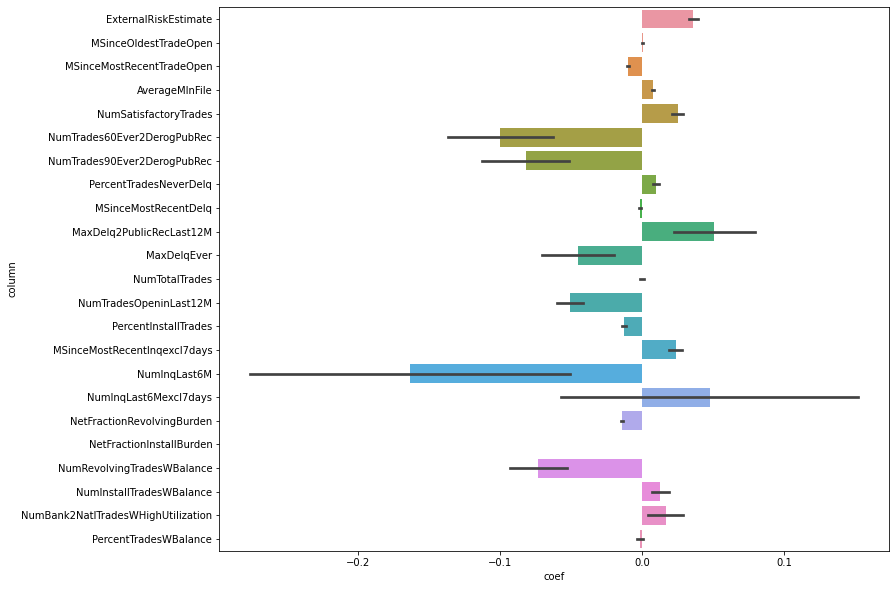

In [17]:
plt.figure(figsize=(12, 10))

# plots means (std) of coefs from 10-fold (outer) cv
sns.barplot(data=coefs_df, x='coef', y='column', estimator=np.mean, ci='sd');